<a href="https://colab.research.google.com/github/tirthasheshpatel/Generative-Models/blob/gans/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%shell
cd /content
flag=0
for FILE in `ls -a`
do
    if [[ $FILE == "Generative-Models" ]]
    then
        cd $FILE
        git pull origin master
        flag=1
        break
    fi
done

if [[ flag -ne 1 ]]
then
    git clone https://github.com/tirthasheshpatel/Generative-Models.git
    cd "Generative-Models"
fi

From https://github.com/tirthasheshpatel/Generative-Models
 * branch            master     -> FETCH_HEAD
Already up to date.


In [2]:
%cd /content/Generative-Models
%tensorflow_version 1.x
import functools
import numpy as np
import tensorflow as tf
import keras
from keras import Input
from keras.models import Sequential, Model
from keras.layers import InputLayer, Dense, Lambda, Reshape
from keras.datasets import mnist
from keras.utils import np_utils
import keras.backend as K

# Start tf session so we can run code.
sess = tf.InteractiveSession()
# Connect keras to the created session.
K.set_session(sess)

/content/Generative-Models
TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
def discriminator_loss(gen_label, true_label):
    disc_loss = tf.reduce_mean(tf.log(true_label) + tf.log(1 - gen_label))
    return -disc_loss

def generator_loss(gen_label):
    gen_loss = tf.reduce_mean(tf.log(gen_label))
    return -gen_loss

In [0]:
batch_size = 100
image_dims = 784 # Number of pixels in MNIST images.
latent_dims = 3 # d, dimensionality of the latent code t.
intermediate_dims = 128 # Size of the hidden layer.
epochs = 20
lr_disc = 0.00002
lr_gen = 0.0001

In [0]:
def get_discriminator(image_dims):
    model = Sequential(name="discriminator")
    model.add(InputLayer([image_dims]))
    model.add(Dense(intermediate_dims, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

def get_generator(latent_dims, image_dims):
    model = Sequential(name="generator")
    model.add(InputLayer([latent_dims]))
    model.add(Dense(intermediate_dims, activation='relu'))
    model.add(Dense(image_dims, activation='sigmoid'))
    return model

def get_sample(sample_shape):
    samples = K.random_normal(sample_shape)
    return samples

get_sample = functools.partial(get_sample, sample_shape=[batch_size, latent_dims])

In [6]:
discriminator = get_discriminator(image_dims)
generator = get_generator(latent_dims, image_dims)
sampling = Lambda(lambda x: get_sample())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
x = Input(batch_shape=(batch_size, image_dims))

In [0]:
# Let's create and compile our discriminator first
true_label = discriminator(x)
sample_z = sampling(x)
gen_sample = generator(sample_z)
gen_label = discriminator(gen_sample)

In [0]:
disc_loss = discriminator_loss(gen_label, true_label)
discriminator_model = Model(x, gen_label)

discriminator_model.compile(optimizer=keras.optimizers.Adam(lr=lr_disc), loss=lambda *args, **kwargs: disc_loss)

In [0]:
# Let's create and compile our generator now
sample_z = sampling(x)
gen_sample = generator(sample_z)
gen_label = discriminator(gen_sample)

In [0]:
gen_loss = generator_loss(gen_label)
generator_model = Model(x, gen_sample)

generator_model.compile(optimizer=keras.optimizers.Adam(lr=lr_gen), loss=lambda *args, **kwargs: gen_loss)

In [12]:
discriminator_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (100, 784)                0         
_________________________________________________________________
lambda_1 (Lambda)            (100, 3)                  0         
_________________________________________________________________
generator (Sequential)       multiple                  101648    
_________________________________________________________________
discriminator (Sequential)   multiple                  100609    
Total params: 202,257
Trainable params: 202,257
Non-trainable params: 0
_________________________________________________________________


In [13]:
generator_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (100, 784)                0         
_________________________________________________________________
lambda_1 (Lambda)            (100, 3)                  0         
_________________________________________________________________
generator (Sequential)       multiple                  101648    
Total params: 101,648
Trainable params: 101,648
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# One hot encoding.
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [29]:
for _ in range(100):
    print("Trining Discriminator")
    hist = discriminator_model.fit(x=x_train, y=x_train,
                                    shuffle=True,
                                    epochs=1,
                                    batch_size=batch_size,
                                    validation_data=(x_test, x_test),
                                    verbose=2)
    print("Training Generator")
    hist = generator_model.fit(x=x_train, y=x_train,
                                shuffle=True,
                                epochs=1,
                                batch_size=batch_size,
                                validation_data=(x_test, x_test),
                                verbose=2)

Trining Discriminator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 2s - loss: 0.0013 - val_loss: 9.9162e-04
Training Generator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 1s - loss: 0.2706 - val_loss: 0.0033
Trining Discriminator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 2s - loss: 0.0971 - val_loss: 0.0150
Training Generator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 1s - loss: 0.1604 - val_loss: 0.0035
Trining Discriminator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 2s - loss: 0.2390 - val_loss: 0.0660
Training Generator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 1s - loss: 0.1168 - val_loss: 0.0037
Trining Discriminator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 2s - loss: 0.3514 - val_loss: 0.0935
Training Generator
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 - 1s - loss: 0.1278 - val_loss: 0.0038
Trining Discriminator
Train on 6

KeyboardInterrupt: ignored

In [0]:
generated = sess.run(gen_sample, feed_dict={})

In [0]:
import matplotlib.pyplot as plt

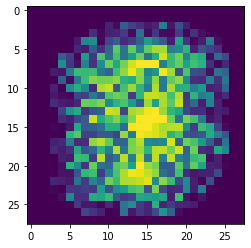

In [32]:
plt.imshow(generated[0].reshape(28, 28));